# Transitional Dynamics

Question: how does the transition until the long-run equilibrium look like?
- it will take time to reach the new equilibrium.
- short- or medium-run effects might be different from long-run, critical for welfare of different generations/cohorts.

How to solve the transition path?
1. Solve the long-run equilibrium in the long run with a change of interest (e.g., lower $\theta$)
2. Set the length of time horizon $T$. Choose $T$ so that it is large enough for the economy to converge.
3. Make initial guesses for the time series of prices.
4. Given the prices, solve the household problems.
5. Compute the implied series of aggregate variables based on the household decisions.
6. Check if the guess is close enough to the implied series. If not, update the guesses and go back to step 4 until convergence.

## Model
To focus on the essence of computational algorithm for transitional dynamics, we use a two-period model with exogenous labor supply but consider an parental investments and endogenous human capital (this is a useful setup to see that it takes time to reach the final economy upon some exogenous changes in environment). The problem is:

$$
\max_{c^y_t,c^o_{t+1}} ~ \ln(c^y_t) + \gamma\ln(q) + \beta\ln(c^o_{t+1})
$$
subject to:
$$
c^y_t + (1-s_t)p e_t + a_{t+1} = (1-\tau_t)w_t h_t\\
c^o_{t+1} = (1+r_{t+1})a_{t+1} \\
h_{t+1} = H(e) = \theta + B e_t^\kappa \\
q_t = h_{t+1}
$$
Here, $e$ denotes the money spent in children, $p$ denotes the price of the investment goods, $s_t$ is the subsidy rate of educational investments, and $H(e)$ is the human capital production function. The older (parent) generation gains utility from the quality of children. 

Firm uses capital and labor to produce final output according to the production function $F(K,N)=K_t^{\alpha}N_t^{1-\alpha}$. Given that labor supply is exogenous but human capital level is endogenous, $N_t=h_t$. Also, capital market clearing implies that $K_t=a_{t+1}$. 

The tax rate $\tau_t$ is determined so that it satisfies the government budget constraint:

$$
\tau_t w_t h_t \mu^y_t = s_t p e_t \mu^y_t
$$

This means that the equilibrium tax rate is determined as
$$
\tau_t = \frac{s_t p e_t}{w_t h_t}
$$

Think that the population growth rate is zero (ie., $\mu^o_t=\mu^y_t$).

In equilibrium prices are given as:
$$
r = \alpha (K/N)^{\alpha-1} 
$$
and
$$
w = (1-\alpha) (K/N)^{\alpha}
$$

In stationary equilibrium, human capital level is constant across generations: $h_t=h_{t+1}$ for any $t>0$.


In [97]:
# deep parameters
β=0.8
γ=1.0
p=1.0
θ=0.2
B=0.9
κ=0.5
α=0.33

# policy parameters
s = 0.0

# equilibrium objects
r = 0.1
w = 1.0
τ = 0.0

h = 1.0

1.0

In [98]:
# function to solve household problem
using Roots # we will learn the algorithm for root finding as well in Lecture 9.

function household(h,w,r,τ,s;β=β, γ=γ, p=p, θ=θ, B=B, κ=κ)

    # step 1. guess c0
    c0 = 0.5
    c1 = 0.0
    e  = 0.0

    d=1.0
    ε=1.e-5
    iter=1
    maxiter=10000
    adj=0.001

    while (d>ε && iter<maxiter)

        # step 2. compute the implied allocation based on guessed c0
            # pin down c1 from the FOC
            c1 = β*(1+r)*c0

            # find optimal e given c0
            f(e) = γ/(θ+B*e^κ) * B*κ*e^(κ-1) - (1-s)*p/c0
            e = find_zero(f, (1e-6, 10.0))

        # step 3. check if the implied allocation satisfies budget constraint with equality
        spending = c0 + (1-s)*p*e + c1/(1+r)
        income = (1-τ)*w*h

        d=abs(spending-income)

        # step 4. update
        if (d>ε)
            if (spending>income) # c0 needs to be lower
                c0=(1-adj)*c0
            else # c0 needs to be higher
                c0=(1+adj)*c0
            end
            iter+=1
        end
    end
    
    return c0,c1,e
end

household (generic function with 1 method)

In [99]:
# function to find the stationary h
function fixed_point_h(h0,w,r,τ,s;β=β, γ=γ, p=p, θ=θ, B=B, κ=κ)

    
    # step 1: guess h
    # h0: initial guess
    h = h0

    adj=0.5
    d=1.0
    ε=1.e-5
    iter=1
    maxiter=10000

    while (d>ε && iter<maxiter)
    
        # step 2: compute implied h
        c0,c1,e = household(h,w,r,τ,s;β=β, γ=γ, p=p, θ=θ, B=B, κ=κ)
        imp_h = θ + B*e^κ

        d = abs(h-imp_h)

        if (d>ε)
            h=adj*imp_h+(1.0-adj)*h
            iter+=1
        end

    end    

    return h
    
end

fixed_point_h (generic function with 1 method)

In [100]:
h0=1.0
h = fixed_point_h(h0,w,r,τ,s;)
c0,c1,e = household(h,w,r,τ,s;)
@show h,c0,c1,e

(h, c0, c1, e) = (0.3977150421338441, 0.19414849082977012, 0.17085067193019773, 0.04825741982622047)


(0.3977150421338441, 0.19414849082977012, 0.17085067193019773, 0.04825741982622047)

In [101]:
# function to solve GE
function solve_GE(h0,w0,r0,τ0,s;β=β, γ=γ, p=p, θ=θ, B=B, κ=κ, α=α)

    w=w0
    r=r0
    τ=τ0

    # for output
    K=0.0
    N=0.0
    Y=0.0

    adj=0.5
    d=1.0
    ε=1.e-4
    iter=1
    maxiter=1000
    while (d>ε  && iter<maxiter)

        # solve equilibrium allocations given prices and tax
        h = fixed_point_h(h0,w,r,τ,s;)
        c0,c1,e = household(h,w,r,τ,s;)

        K = c1/(1+r)
        N = h
        Y = K^α * N^(1-α)

        imp_r = α*(K/N)^(α-1)
        imp_w = (1-α)*(K/N)^α
        imp_τ=(s*p*e)/(w*h)

        d = max(abs(r-imp_r),abs(w-imp_w),abs(τ-imp_τ))
        if (d>ε)
            # update
            r = adj*imp_r + (1-adj)*r
            w = adj*imp_w + (1-adj)*w
            τ = adj*imp_τ + (1-adj)*τ

            h0=h

            iter+=1
        end

        # @show iter,d

    end

    return w,r,τ,Y,K,N # prices (w,r,τ) and quantities (Y,K,N)
end

solve_GE (generic function with 1 method)

In [102]:
w0=w
r0=r
τ0=τ
s=0.0
h0=1.0
w,r,τ,Y,K,N=solve_GE(h0,w0,r0,τ0,s;β=β, γ=γ, p=p, θ=θ, B=B, κ=κ, α=α)

(0.35599779234980666, 1.1914920063422194, 0.0, 0.14584750141671524, 0.04039133503035847, 0.2745004821845177)

In [113]:
# Transition

# consider introducing education subsidy
s_old = 0.0
s_new = 0.1

# step 1. solve initial and final stationary equilibria (steady states)
    # initial economy
    h=1.0; w=1.0; r=0.2; τ=0.0;
    w0,r0,τ0,Y0,K0,N0=solve_GE(h,w,r,τ,s_old;)
    # new equilibrium (use equilibrium objects in initial economy for initla guesses)
    w1,r1,τ1,Y1,K1,N1=solve_GE(N0,w0,r0,τ0,s_new;)

    # @show τ1
    # @show N0,N1,N1/N0
    # @show Y0,Y1,Y1/Y0

# step 2. set the length of period for transition
    T = 10

# step 3. make initial guesses for prices and tax
    s_t=zeros(T); s_t[1]=s_old; s_t[2:T].=s_new;

    r_t = collect(LinRange(r0,r1,T)) 
    w_t = collect(LinRange(w0,w1,T))
    τ_t = collect(LinRange(τ0,τ1,T)) 

    # for output
    K_t = collect(LinRange(K0,K1,T)); K_t[2]=K0;
    N_t = collect(LinRange(N0,N1,T)); N_t[2]=N0;
    Y_t = collect(LinRange(Y0,Y1,T)); Y_t[2]=Y0;

    d_vec = zeros(T) # to stock dif

    d=1.0
    ε=1.e-5
    iter=1
    maxiter=100

    while (d>ε && iter<maxiter)

        # step 4. solve household problem of each cohort, given guessed sequences
        for t in 2:(T-1)
            r=r_t[t]; w=w_t[t]; τ=τ_t[t]; s=s_t[t];

            if (t==2) # in t=2, still human capital and asset remain the same as in the initial economy
                N=N0
                K=K0
            else
                N=N_t[t]
                K=K_t[t]
            end
            
            c0,c1,e = household(N,w,r,τ,s;)
            h_next = θ+B*e^κ

            K_next = c1/(1+r)

            imp_r = α*(K/N)^(α-1)
            imp_w = (1-α)*(K/N)^α
            imp_τ=(s_t[t]*p*e)/(w*N)

            d_vec[t] = maximum((abs(r_t[t]-imp_r),abs(w_t[t]-imp_w),abs(τ_t[t]-imp_τ)))

            # step 5: update
            r_t[t] = (r_t[t]+imp_r)/2.0
            w_t[t] = (w_t[t]+imp_w)/2.0
            τ_t[t] = imp_τ

            K_t[t+1]=K_next
            N_t[t+1]=h_next
            Y_t[t+1]=K_next^α * h_next^(1-α)


        end

        
        d = maximum(d_vec)

        # @show iter,d
        
        iter+=1

    end

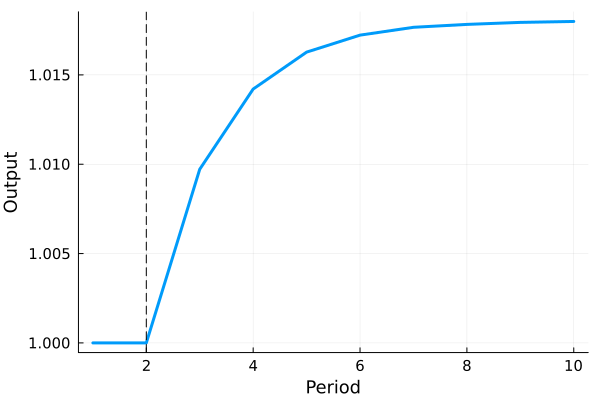

In [104]:
using Plots
# OUTPUT
plot(1:T,Y_t./Y_t[1];
legend=false,
xlabel="Period",                   
ylabel="Output",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

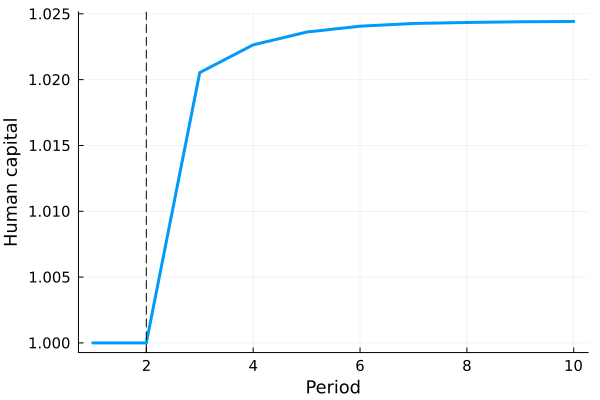

In [105]:
# HUMAN CAPITAL
plot(1:T,N_t./N_t[1];
legend=false,
xlabel="Period",                   
ylabel="Human capital",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

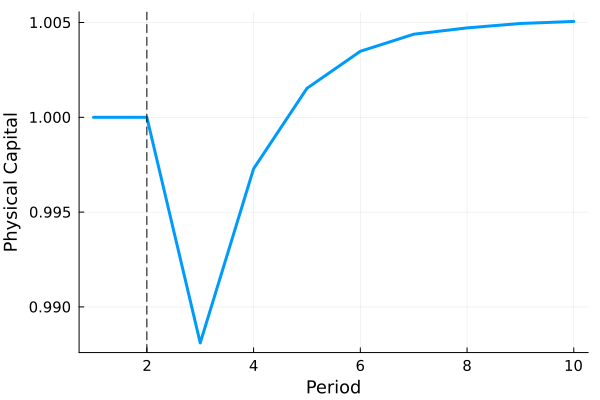

In [106]:
# Physical capital
plot(1:T,K_t./K_t[1];
legend=false,
xlabel="Period",                   
ylabel="Physical Capital",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

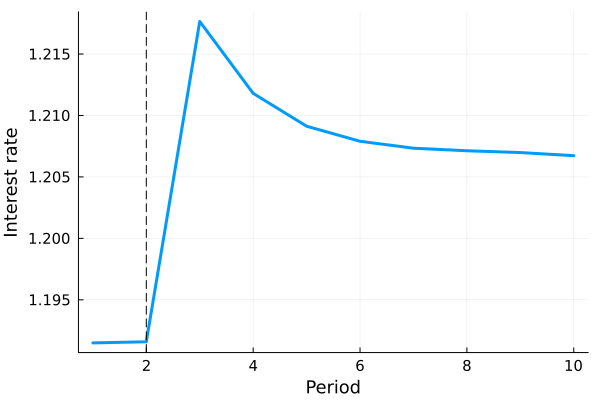

In [107]:
# INTEREST RATE
plot(1:T,r_t;
legend=false,
xlabel="Period",                   
ylabel="Interest rate",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")


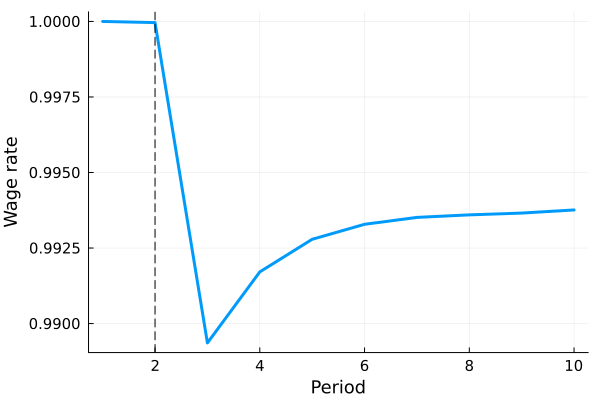

In [108]:
# WAGE RATE
plot(1:T,w_t./w_t[1];
legend=false,
xlabel="Period",                   
ylabel="Wage rate",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

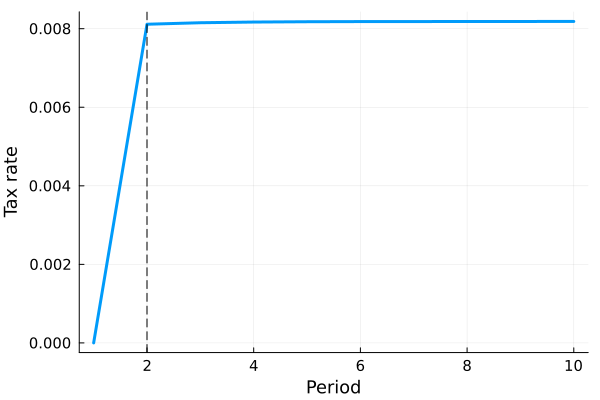

In [109]:
# TAX RATE
plot(1:T,τ_t;
legend=false,
xlabel="Period",                   
ylabel="Tax rate",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")


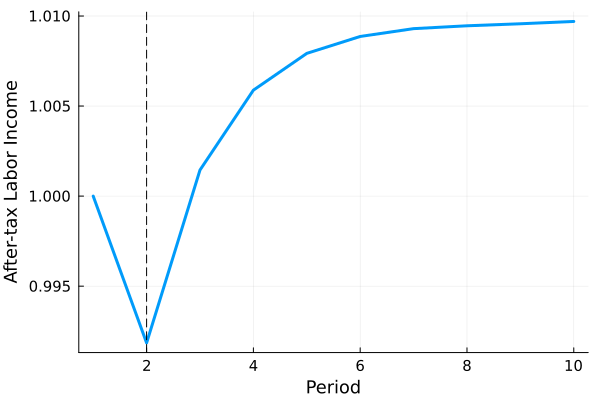

In [110]:
# (AFTER-TAX) LABOR INCOME
plot(1:T,(1.0.-τ_t).*w_t.*N_t./((1-τ_t[1])*w_t[1]*N_t[1]);
legend=false,
xlabel="Period",                   
ylabel="After-tax Labor Income",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")

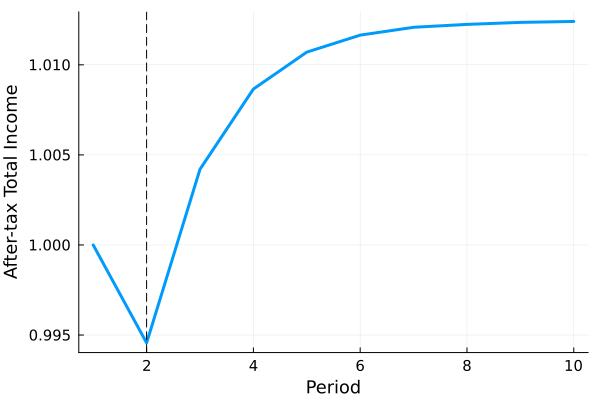

In [112]:
# AFTER-TAX TOTAL INCOME
plot(1:T,((1.0.-τ_t).*w_t.*N_t .+ r_t.*K_t)./((1-τ_t[1])*w_t[1]*N_t[1]+r_t[1]*K_t[1]);
legend=false,
xlabel="Period",                   
ylabel="After-tax Total Income",
linewidth=3,
guidefont=font(12),
tickfont=font(10),
legendfont=font(10))
vline!([2], color=:black, linestyle=:dash, label="")